# Machine learning german bank's credit scoring
In this project, I will build a <b>machine learning model to predict the default probability of German Bank's customers and assign them credit scores.</b> It involves <b>supervised learning</b>, using a labeled training set, for <b>classification.</b> The <b>target</b> variable is set to <b>1</b> if the customer represents a <b>bad risk (interpreted as default)</b>, and <b>0</b> if the customer represents a <b>good risk (interpreted as not default).</b>

I will use the following <b>pipeline:</b>

<b>1. Define the business problem.</b><br>
<b>2. Collect the data and get a general overview of it.</b><br>
<b>3. Split the data into train and test sets.</b><br>
<b>4. Explore the data (exploratory data analysis)</b><br>
<b>5. Data cleaning and preprocessing.</b><br>
<b>6. Model training, comparison, selection and tuning.</b><br>
<b>7. Final production model testing and evaluation.</b><br>
<b>8. Conclude and interpret the model results.</b><br>
<b>9. Deploy.</b><br>


In <b>this notebook</b>, I will perform <b>machine learning modelling, covering steps 5 to 8 of the pipeline above</b>. The main <b>objective</b> here is to <b>build a model that is able to differentiate well between customers who will default on loans and those who will not.</b> Thus, I will <b>focus on the ROC-AUC score.</b> Furthermore, I will approach these steps in more detail below, providing an overview of each step and explaining the rationale behind each decision.

### Importing the libraries

In [416]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Fixing some errors.
np.int = int
import math

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Utils
from notebooks.modelling_utils import *

### Reading the dataset

In [268]:
df = pd.read_csv('data/german_credit_data.csv')
# Dropping irrelevant column.
df.drop(columns=['Unnamed: 0'], inplace=True)

In [269]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


I will rename the columns in order to turn data manipulation easier. The target will be renamed as 'Default' for interpretation purposes.

In [270]:
df.columns = [x.lower().replace(' ', '_') for x in df.columns]
df.rename(columns={'risk': 'default'}, inplace=True)

Target (default) and sex can be expressed as binary features. I will label bad risk as 1 and good risk as 0 because the main focus will be in accurately predicting potential defaulters. Moreover, I will label male as 1 and female as 0.

In [271]:
df['default'] = df['default'].map({'bad': 1, 'good': 0})
df['sex'] = df['sex'].map({'male': 1, 'female': 0})

### Split the data into train and test sets
- Test set is supposed to be data the model has never seen before.
- This split will avoid data leakage, which occurs when information from the test set or future data inadvertently leaks into the training process, leading to over-optimistic performance estimate, compromising the model's ability to generalize to new, unseen data.
- I will specify stratify=y so that the train_test_split function ensures that the splitting process maintains the same percentage of each target class in both the training and testing sets. This is particularly useful when dealing with imbalanced datasets, which is the case, as there are more defaulters. Stratification will enable a more accurate evaluation of the model's performance.

In [272]:
X = df.drop(columns=['default'])
y = df['default'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [273]:
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (800, 9).
Train target dataset shape: (800,).
Test predictor dataset shape: (200, 9).
Test target dataset shape: (200,).


In [274]:
print(f'Train target classes proportions: ')
print(y_train.value_counts(normalize=True))
print(f'\nTest target classes proportions:')
print(y_test.value_counts(normalize=True))

Train target classes proportions: 
default
0    0.7
1    0.3
Name: proportion, dtype: float64

Test target classes proportions:
default
0    0.7
1    0.3
Name: proportion, dtype: float64


The train-test-split was succesfull and each target class proportion was preserved in both sets.

# 5. Data cleaning and preprocessing
In order to fit machine learning algorithms, it is necessary to apply some transformations to the data.

- <b>Impute missing values:</b> There are some missing values in saving accounts and checking account. I will replace them with mode. Dropping the null values is not a good choice because I have a little amount of data (just 1000 rows).<br>
- <b>Outliers:</b> In the eda step, I investigated the outliers and saw that they don't represent inconsistent information like measurement errors. Thus, considering this and the fact that I have a little amount of data, I will not drop or treat any.<br>
- In order to train tree-based algorithms, it is not necessary to scale the data. However, as I intend to test a different algorithms, I will apply standard scaler on numerical and categorical features (after encoding). By doing this, it will be possible to compare all models at once.
- <b>Numerical features:</b> Some algorithms are sensitive to feature scaling because they use distance calculations or optimizations like gradient descent for being trained, which are affected by scale. Thus, I will apply StandardScaler on numeric attributes.<br>
- <b>Categorical features:</b> Machine learning algorithms make mathematical calculations, so it's necessary to convert the categoric attributes to numeric by applying encoding techniques. Saving accounts and checking account present ordinal relationships while purpose has a higher cardinality. My hypothesis is that ordinal encoding in saving and checking accounts and target encoding in purpose and housing will perform better than one-hot encoding all the features. As a good data scientist, I will create two preprocessors and asses wheter my hypothesis is true by comparing the models performances on stratified k-fold cross validation by when trained with each preprocessing approach.

In [275]:
X_train.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose
828,47,1,2,free,NaN,little,8335,36,car
997,38,1,2,own,little,NaN,804,12,radio/TV
148,28,1,2,own,little,little,5371,36,furniture/equipment
735,29,0,0,own,NaN,moderate,3990,36,domestic appliances
130,24,0,2,own,NaN,moderate,8487,48,car


Checking missing values.

In [276]:
X_train.isna().sum()

age                   0
sex                   0
job                   0
housing               0
saving_accounts     144
checking_account    316
credit_amount         0
duration              0
purpose               0
dtype: int64

Checking numerical features.

In [277]:
numerical_features = X_train.select_dtypes('number').columns.to_list()
print(f'There are {len(numerical_features)} numerical features. They are: {numerical_features}')

There are 5 numerical features. They are: ['age', 'sex', 'job', 'credit_amount', 'duration']


Checking categorical features cardinality and unique values.

In [278]:
categorical_features = X_train.select_dtypes('object').columns.to_list()

print(f'There are {len(categorical_features)} categorical features. They are: {categorical_features}')
print()

for feature in categorical_features:
    print(feature)
    print(f'Number of categories: {X_train[feature].nunique()}. They are:')
    print(X_train[feature].unique())
    print()

There are 4 categorical features. They are: ['housing', 'saving_accounts', 'checking_account', 'purpose']

housing
Number of categories: 3. They are:
['free' 'own' 'rent']

saving_accounts
Number of categories: 4. They are:
[nan 'little' 'moderate' 'rich' 'quite rich']

checking_account
Number of categories: 3. They are:
['little' nan 'moderate' 'rich']

purpose
Number of categories: 8. They are:
['car' 'radio/TV' 'furniture/equipment' 'domestic appliances' 'education'
 'repairs' 'vacation/others' 'business']



I will build the preprocessors below. As I have mentioned above, once I intend to test different algorithms at once, I will scale all the features excepting one-hot encoded ones (it is not necessary).

In [279]:
target_encoder_features = ['purpose', 'housing']
ordinal_encoder_features = ['saving_accounts', 'checking_account']

Preprocessor 1: Applying ordinal encoding to saving and checking accounts (after imputing missing values with mode) and target encoding to purpose and housing. Then, I will apply standard scaling to all the features.

In [280]:
ordinal_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), 
        ('ordinal_encoder', OrdinalEncoder()),
        ('std_scaler', StandardScaler())
        ]
        )

target_pipeline = Pipeline(
    steps=[
        ('target_encoder',TargetEncoder(cols=target_encoder_features)), 
        ('std_scaler', StandardScaler())
        ]
        )

preprocessor_ordinal_target = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', ordinal_pipeline, ordinal_encoder_features),
        ('target_encoder', target_pipeline, target_encoder_features),
        ('std_scaler', StandardScaler(), numerical_features)
        ], remainder='passthrough'
        )

Preprocessor 2: Applying one-hot encoding to all the categorical features and standard scaling to the numerical features.

In [281]:
preprocessor_onehot = ColumnTransformer([
    ('one-hot_encoder', OneHotEncoder(), categorical_features),
    ('std_scaler', StandardScaler(), numerical_features)
], remainder='passthrough')

Preprocessing the train predictor dataset with both preprocessors constructed.

In [282]:
X_train_prepared_ordinal_target = preprocessor_ordinal_target.fit_transform(X_train, y_train)
X_train_prepared_ordinal_target.shape

(800, 9)

In [283]:
X_train_prepared_onehot = preprocessor_onehot.fit_transform(X_train, y_train)
X_train_prepared_onehot.shape

(800, 25)

Look how one-hot encoding the categorical features increased dimensionality. In theory, this will favor overfitting since we have a little amount of data and thus present a worse performance. Let's see it below with cross validation.

# 6. Model training, comparison, selection and tuning
- In this step, I intend to compare different models' performances. In order to achieve this, I will use stratified k-fold cross validation to train each one of them, evaluating their roc-auc score.
- The roc-auc score is the metric of focus when building a credit scoring model because it effectively measures the model's ability to discriminate between defaulters and non-defaulters, providing a comprehensive evaluation of its predictive power. 
- Accuracy is not a good metric because the target is imbalanced. Moreover, stratified k-fold cross-validation will maintain the target proportion in each fold, enabling a more accurate evaluation of the models' performances. These two strategies are efficient for dealing with imbalanced data.
- My objective here is to select a best model to go for hyperparameter tuning. In order to get this best model, I will evaluate the highest roc-auc average validation scores and look at the bias-variance trade-off.

Dictionary of models for training and performance comparison.

In [341]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear SVM': LinearSVC(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

Training and comparing the models' performances on the predictor train set transformed by applying the 'preprocessor_ordinal_target'.

Logistic Regression results: 
--------------------------------------------------
Training score: 0.5604166666666667
Average validation score: 0.6814732142857143
Standard deviation: 0.039292407325782576
Training time: 0.00599 seconds

Linear SVM results: 
--------------------------------------------------
Training score: 0.5502976190476191
Average validation score: 0.6812872023809524
Standard deviation: 0.03888469311341752
Training time: 0.02881 seconds

SVM results: 
--------------------------------------------------
Training score: 0.5848214285714286
Average validation score: 0.6314360119047618
Standard deviation: 0.034016608903587084
Training time: 0.0188 seconds

K-Nearest Neighbors results: 
--------------------------------------------------
Training score: 0.6693452380952382
Average validation score: 0.6074032738095239
Standard deviation: 0.0334894481944407
Training time: 0.001 seconds

Random Forest results: 
--------------------------------------------------
Training score: 1.0


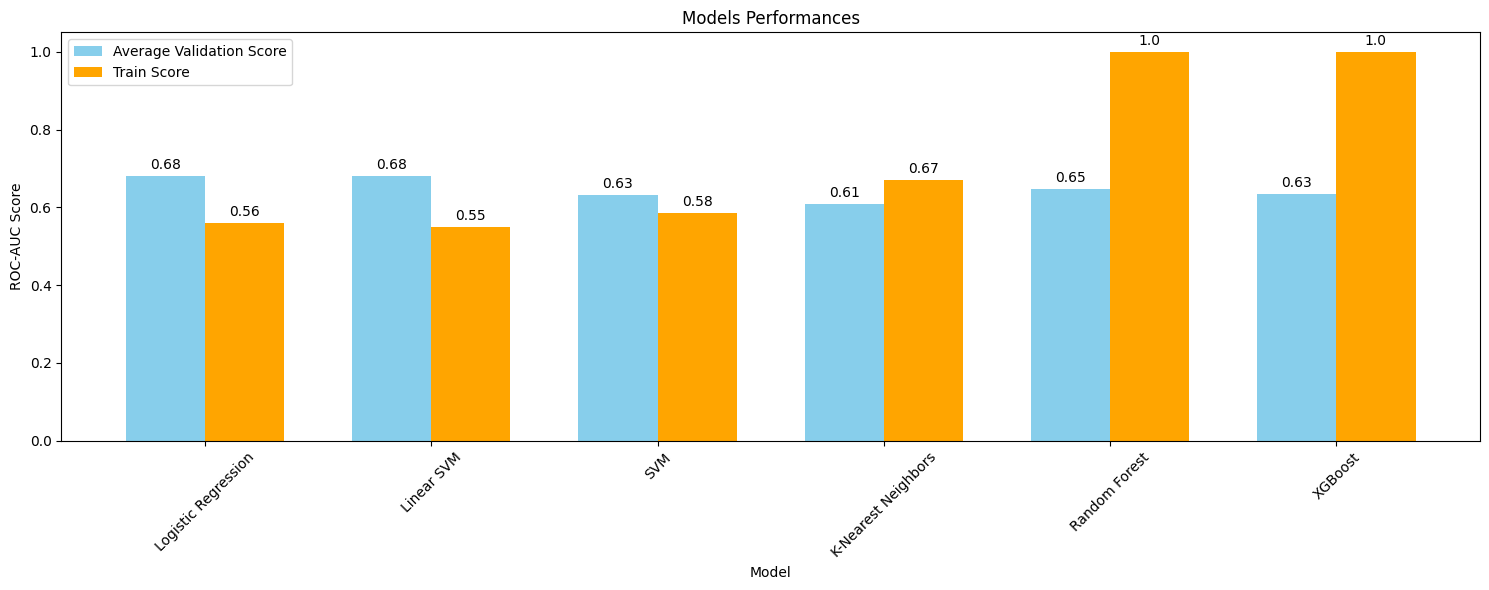

In [347]:
eval_df_ordinal_target = evaluate_models_cv(models=models, X_train=X_train_prepared_ordinal_target, y_train=y_train)

In [348]:
eval_df_ordinal_target.sort_values(['Average Val Score'], ascending=False).reset_index(drop=True)

,Model,Average Val Score,Train Score
0,Logistic Regression,0.681473,0.560417
1,Linear SVM,0.681287,0.550298
2,Random Forest,0.647768,1.000000
3,XGBoost,0.634859,1.000000
4,SVM,0.631436,0.584821
5,K-Nearest Neighbors,0.607403,0.669345


Training and comparing the models' performances on the predictor train set transformed by applying the 'preprocessor_onehot'.

Logistic Regression results: 
--------------------------------------------------
Training score: 0.6577380952380951
Average validation score: 0.7477306547619047
Standard deviation: 0.05619658233002603
Training time: 0.01522 seconds

Linear SVM results: 
--------------------------------------------------
Training score: 0.6467261904761904
Average validation score: 0.7428571428571428
Standard deviation: 0.05764095654007304
Training time: 0.02724 seconds

SVM results: 
--------------------------------------------------
Training score: 0.7160714285714286
Average validation score: 0.7561755952380953
Standard deviation: 0.03447647231904331
Training time: 0.01041 seconds

K-Nearest Neighbors results: 
--------------------------------------------------
Training score: 0.6982142857142857
Average validation score: 0.6604724702380953
Standard deviation: 0.04158939176516276
Training time: 0.00076 seconds

Random Forest results: 
--------------------------------------------------
Training score: 1.

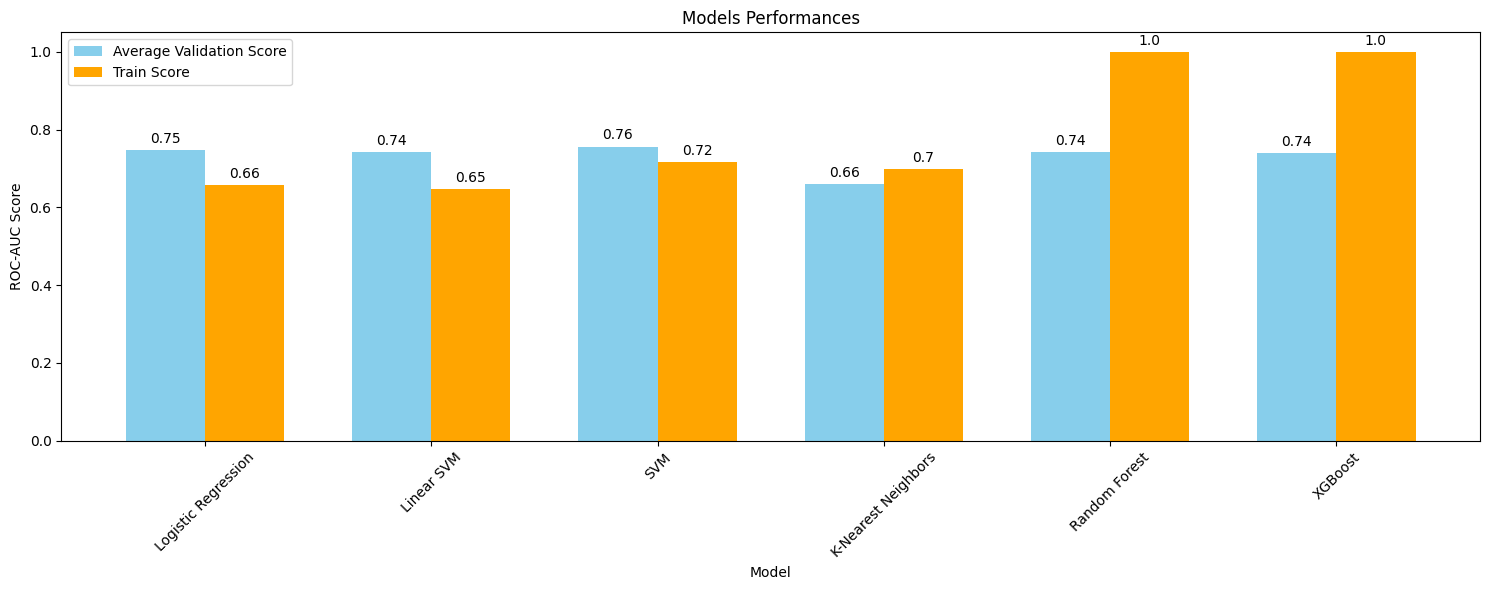

In [342]:
eval_df_onehot = evaluate_models_cv(models=models, X_train=X_train_prepared_onehot, y_train=y_train)

In [345]:
eval_df_onehot.sort_values(['Average Val Score'], ascending=False).reset_index(drop=True)

,Model,Average Val Score,Train Score
0,SVM,0.756176,0.716071
1,Logistic Regression,0.747731,0.657738
2,Linear SVM,0.742857,0.646726
3,Random Forest,0.742318,1.000000
4,XGBoost,0.739621,1.000000
5,K-Nearest Neighbors,0.660472,0.698214


- Wow! Surprisingly, one-hot encoding all the categorical features presented a better performance for this case. Thus, I will stick with the 'preprocessor_onehot'.
- SVM presents the highest average validation roc-auc score. Furthermore, Random Forest is overfitting. There is a significant difference between its validation and training errors. In fact, the training error is about zero. Thus, the Random Forest model exhibits low bias and high variance. 
- Since there is just a few difference between Random Forest and SVM roc-auc scores, I will choose Random Forest for hyperparameter tuning and final model evaluation because there is more room for performance improvement with it (due to the overfit).

### Hyperparameter tuning
As I intend to tune Random Forest model, I won't use GridSearchCV.

Why not use grid search?

Using grid search CV to tune Random Forest can be problematic due to its computational expense, limitations in granularity and adaptability, lack of consideration for interaction effects, inefficient exploration of the hyperparameter space, and inefficient allocation of computational resources.
Grid search exhaustively searches through all combinations of specified hyperparameters, it does not adapt its search based on the observed performance of previous hyperparameter configurations. Also, hyperparameters in Random Forest can have complex interactions, where the impact of one hyperparameter depends on the values of others. Grid search does not explicitly consider these interactions and evaluates hyperparameters independently. 
Considering this, I will tune Random Forest using Bayesian Optimization.

What is Bayesian Optimization?

Bayesian optimization is an efficient and adaptive technique for finding the optimal combination of hyperparameters for a machine learning model. It uses probabilistic models to intelligently explore the hyperparameter space, balancing exploration and exploitation.

An important point here is to define class_weight hyperparameter. This hyperparameter assigns varying weights to instances of the minority class (defaulters) and the majority class (non-defaulters). As a result, the model will face penalties for incorrect predictions of defaulters and will have an improved ability to capture patterns within the minority class data samples.

In [351]:
n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

search_space = {
    'n_estimators': Integer(100, 700),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'max_depth': Integer(2, 16),
    'min_samples_split': Integer(2, 50),
    'min_samples_leaf': Integer(2, 25),
    'bootstrap': Categorical([True, False]),
    'class_weight': Categorical(['balanced', 'balanced_subsample']),
    'max_features': Categorical(['sqrt', 'log2', None])
}

bayesian_search = BayesSearchCV(estimator=RandomForestClassifier(), search_spaces=search_space, cv=stratified_kfold, n_iter=50, scoring='roc_auc', return_train_score=True, random_state=42)

In [352]:
bayesian_search.fit(X_train_prepared_onehot, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=RandomForestClassifier(), random_state=42,
              return_train_score=True, scoring='roc_auc',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'class_weight': Categorical(categories=('balanced', 'balanced_subsample'), prior=None),
                             'criterion': Categorical(...
                             'max_depth': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2', None), prior=None),
                             'min_samples_leaf': Integer(low=2, high=25, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=700, prior='uniform', transform='normalize')})

In [357]:
print(f'The best params fund for Random Forest are: ')
bayesian_search.best_params_

The best params fund for Random Forest are: 


OrderedDict([('bootstrap', True),
             ('class_weight', 'balanced_subsample'),
             ('criterion', 'log_loss'),
             ('max_depth', 6),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 8),
             ('min_samples_split', 40),
             ('n_estimators', 100)])

Let's take a look into some results obtained by the bayesian search cv, specially for important parameters like class_weight, criterion, max_depth, min_samples_leaf, min_samples_split and n_estimators.

In [358]:
bayesian_search_results = pd.DataFrame(bayesian_search.cv_results_)
bayesian_search_results = bayesian_search_results[['rank_test_score', 'mean_test_score', 
'mean_train_score', 'param_class_weight', 
'param_criterion', 'param_max_depth', 
'param_min_samples_leaf', 'param_min_samples_split', 
'param_n_estimators']]
bayesian_search_results.sort_values(['rank_test_score']).head(10)


,rank_test_score,mean_test_score,mean_train_score,param_class_weight,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators
42,1,0.763876,0.839748,balanced_subsample,log_loss,6,8,40,100
3,2,0.763802,0.859489,balanced,gini,13,4,38,624
7,3,0.763207,0.877204,balanced_subsample,gini,14,3,29,115
32,4,0.763170,0.808796,balanced_subsample,log_loss,16,25,50,700
8,5,0.762574,0.874716,balanced_subsample,log_loss,8,7,2,322
1,6,0.762091,0.980915,balanced_subsample,gini,15,3,9,312
33,7,0.762054,0.838242,balanced,log_loss,9,9,50,700
13,8,0.762016,0.808944,balanced,gini,12,25,11,122
47,8,0.762016,0.806719,balanced_subsample,log_loss,16,25,2,100
19,10,0.761793,0.808684,balanced_subsample,entropy,16,25,50,700


I can see that some regularization was applied to the Random Forest model by examining parameters such as n_estimators, min_samples_split, and min_samples_leaf values. Additionally, the training error and bias have increased (the training roc-auc score dropped from 1.0 to 0.839748), while the variance has decreased. Consequently, it was possible to improve the average validation roc-auc score from 0.742318 to 0.763876, which is good. As expected, due to overfitting, there was more room for performance improvement.

# 7. Final production model testing and evaluation
- In this step, I intend to evaluate our final tuned model on test data (simulating production unseen data).
- Once I am facing a credit scoring problem, roc-auc score is the metric of interest. We want the model to differentiate well between customers who will default on loans and those who will not.
- A higher ROC-AUC score suggests that the model is better at ranking customers by their credit risk, which is essential for making informed lending decisions and managing the risk associated with loan portfolios.

Getting the final tuned Random Forest model.

In [422]:
final_rf_clf = bayesian_search.best_estimator_

Using the preprocessor to transform the test predictor set. By applying just transform we avoid data leakage.

In [423]:
X_test_prepared = preprocessor_onehot.transform(X_test)
X_test_prepared.shape

(200, 25)

Making predictions.

In [424]:
final_predictions = final_rf_clf.predict(X_test_prepared)

Getting the default probabilities.

In [425]:
default_probas = final_rf_clf.predict_proba(X_test_prepared)[:, 1]

### Evaluating the final tuned Random Forest model.


              precision    recall  f1-score   support

           0       0.83      0.67      0.74       140
           1       0.47      0.68      0.56        60

    accuracy                           0.68       200
   macro avg       0.65      0.68      0.65       200
weighted avg       0.72      0.68      0.69       200



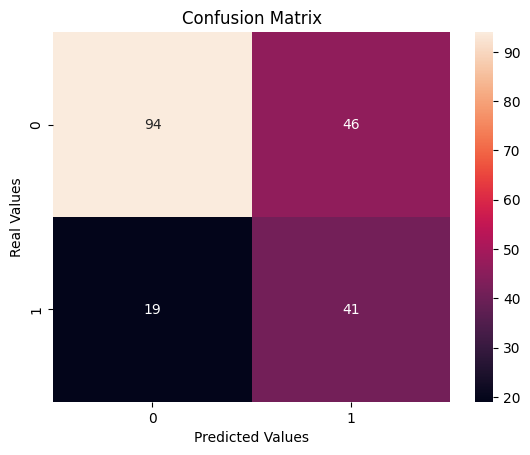

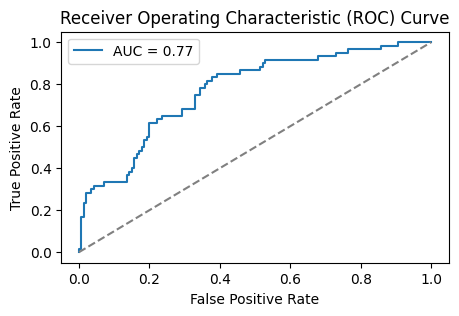

In [426]:
evaluate_classifier(y_test, final_predictions, default_probas)

The model results are great!

<b>ROC-AUC (0.77):</b> With a ROC-AUC score of 0.77, the model demonstrates a good ability to differentiate between defaulters and non-defaulters.<br>
<b>Recall (0.68):</b> The model correctly identifies 68% of the defaulters. In practical terms, looking at the confusion matrix, it has accurately predicted 41 out of 60 defaulters.<br>
<b>Precision (0.47):</b> Out of all customers predicted as default, 47% of them are actually defaulters. In practical terms, considering the confusion matrix, out of 87 customers predicted as default, 41 of them are indeed defaulters.<br>

### Probabilities analysis

I will take a look at some probability plots below in order to interpret the model results and assess how the scores are distributed by defaulters and non-defaulters.

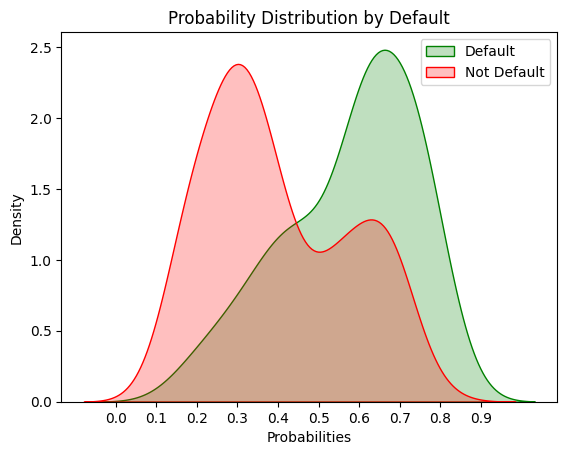

In [475]:
target_probability_distributions(default_probas, y_test, positive_label='Default', negative_label='Not Default')

Plotting the defaulters and non-defaulters distributions by range.

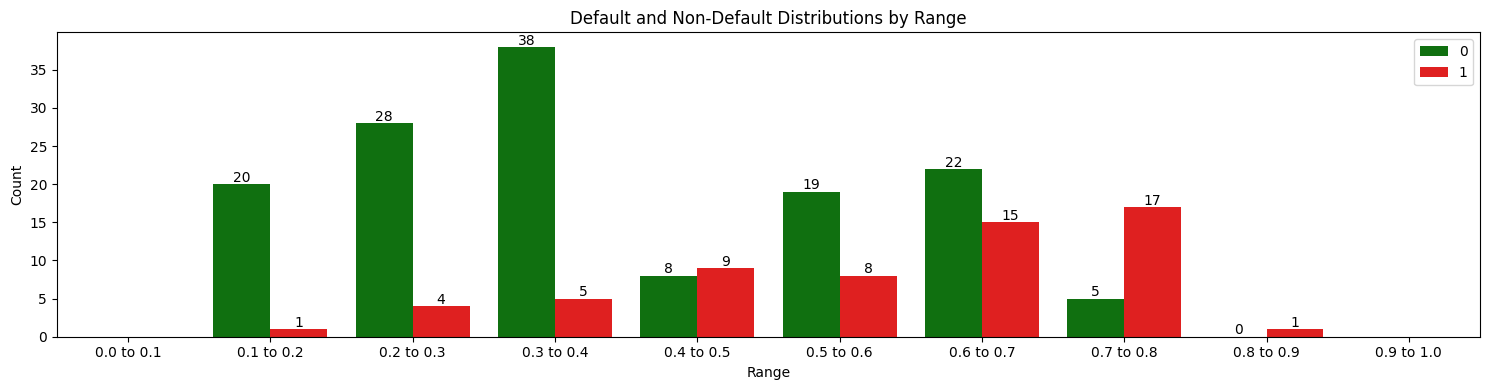

In [477]:
test_scores = target_distributions_by_range(y_test, default_probas, positive_label='Default', negative_label='Non-Default')

Defaulters and non-defaulters proportions by range

In [482]:
# Calculating percentages of default and non-default within each range
range_percentages = test_scores.groupby('Range')['Default'].value_counts(normalize=True).unstack()
range_percentages.rename(columns={0: 'Non-Default', 1: 'Default'}, inplace=True)
range_percentages

Default,Non-Default,Default
Range,,
0.0 to 0.1,0.000000,0.000000
0.1 to 0.2,0.952381,0.047619
0.2 to 0.3,0.875000,0.125000
0.3 to 0.4,0.883721,0.116279
0.4 to 0.5,0.470588,0.529412
0.5 to 0.6,0.703704,0.296296
0.6 to 0.7,0.594595,0.405405
0.7 to 0.8,0.227273,0.772727
0.8 to 0.9,0.000000,1.000000


In [488]:
def target_percentages_by_range(y_true, predicted_probas, positive_label='1', negative_label='0'):
    '''
    Calculate target percentages by score ranges and visualize them with a stacked bar plot.

    This function takes true labels and predicted probabilities, calculates the target percentages
    within predefined score ranges, and displays them in a stacked bar plot.

    :param y_true: True labels or target values.
    :type y_true: array-like

    :param predicted_probas: Predicted probabilities or scores.
    :type predicted_probas: array-like

    :param positive_label: Label for the positive class (default is '1').
    :type positive_label: str

    :param negative_label: Label for the negative class (default is '0').
    :type negative_label: str

    :return: DataFrame containing percentages of default and non-default within each range.
    :rtype: pandas.DataFrame

    :raises CustomException: If an exception occurs during execution.
    '''
    try:
        # Constructing a dataframe with target flag, scores and range columns.
        bins = np.arange(0, 1.1, 0.1)
        bins_labels = [f'{i/10:.1f} to {i/10+0.1:.1f}' for i in range(10)]

        y_true_scores = pd.DataFrame({positive_label: y_true})
        y_true_scores['Scores'] = predicted_probas
        y_true_scores['Range'] = pd.cut(y_true_scores['Scores'], bins=bins, labels=bins_labels)
        y_true_scores.reset_index(drop=True, inplace=True)

        # Constructing a dataframe with percentages of default and non-default within each range.
        range_percentages = y_true_scores.groupby('Range')['Default'].value_counts(normalize=True).unstack().fillna(0)
        range_percentages.reset_index(inplace=True)
        range_percentages.rename(columns={0: 'Non-Default', 1: 'Default'}, inplace=True)
        
        # Creating a stacked bar plot
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Range', y='Default', data=range_percentages, color='green', label='Default')
        sns.barplot(x='Range', y='Non-Default', data=range_percentages, color='red', bottom=range_percentages['Default'], label='Non-Default')

        # Customizing the plot.
        plt.title(f'{positive_label} and {negative_label} Percentages by Range')
        plt.xlabel('Range')
        plt.ylabel('Percentage')
        plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
        plt.xticks(rotation=45)

        # Adding percentages inside the bars.
        for p in range_percentages.index:
            total_height = range_percentages['Default'][p] + range_percentages['Non-Default'][p]
            plt.text(p, range_percentages['Default'][p] / 2, f"{range_percentages['Default'][p]*100:.2f}%", ha='center', color='white', fontsize=10)
            plt.text(p, range_percentages['Default'][p] + range_percentages['Non-Default'][p] / 2, f"{range_percentages['Non-Default'][p]*100:.2f}%", ha='center', color='white', fontsize=10)
        
        plt.tight_layout()
        plt.show()

        return range_percentages
    
    except Exception as e:
        raise CustomException(e, sys)

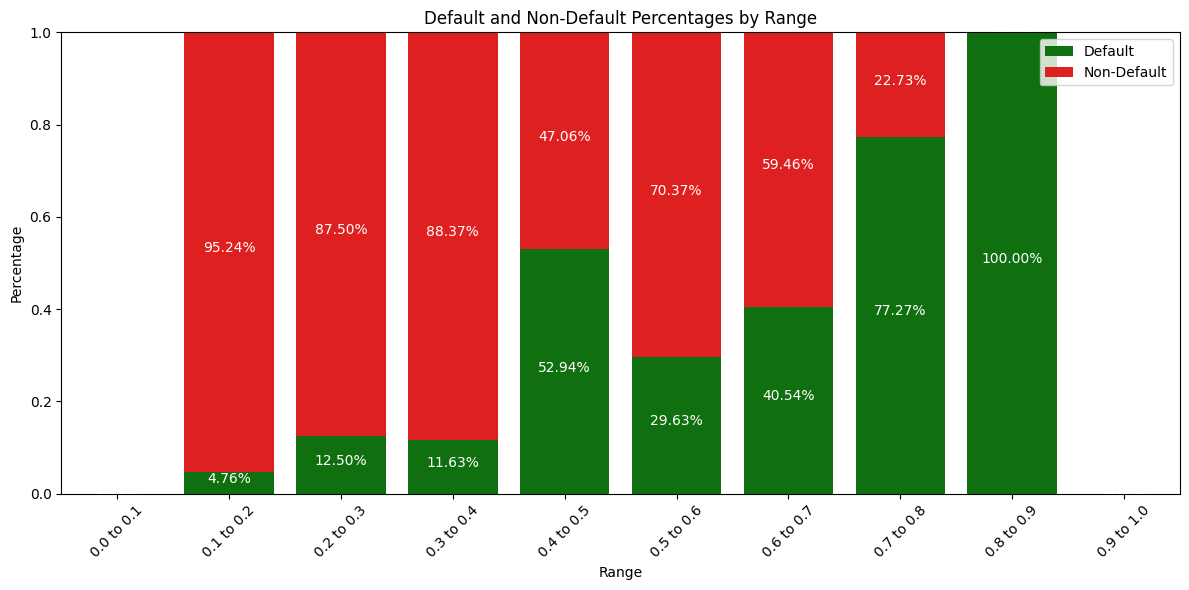

In [509]:
range_percentages_df = target_percentages_by_range(y_test, default_probas, positive_label='Default', negative_label='Non-Default')

In [512]:
range_percentages_df

Default,Non-Default,Default
Range,,
0.0 to 0.1,0.000000,0.000000
0.1 to 0.2,0.952381,0.047619
0.2 to 0.3,0.875000,0.125000
0.3 to 0.4,0.883721,0.116279
0.4 to 0.5,0.470588,0.529412
0.5 to 0.6,0.703704,0.296296
0.6 to 0.7,0.594595,0.405405
0.7 to 0.8,0.227273,0.772727
0.8 to 0.9,0.000000,1.000000
